In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

C:\Users\User\miniconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Current Working directory  C:\Users\User\GitHub\WebET_Analysis


# Read data

In [2]:
data_et_choice = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/data_et_choice.csv')
data_trial_choice = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/data_trial_choice.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/choice_task/data_subject_choice.csv')

overview = pd.DataFrame([[len(data_et_choice)], [len(data_trial_choice)], [len(data_subject)]], 
                        columns=['length'],
                        index=['data_et_choice', 'data_trial_choice', 'data_subject'])
print(overview)

                   length
data_et_choice     630024
data_trial_choice   19409
data_subject          209


# Distribution of choices

# Categorical confounders

In [3]:
data_subject['degree'] = data_subject['degree'].astype('category')
data_subject['degree'].cat.reorder_categories(['middle', 'high', 'college', 'grad'], inplace=True)
data_subject['degree']

0         grad
1      college
2         high
3         high
4      college
        ...   
204    college
205       high
206    college
207    college
208       high
Name: degree, Length: 209, dtype: category
Categories (4, object): ['middle', 'high', 'college', 'grad']

In [4]:
data_subject['fullTime'] = data_subject['Employment Status'].replace({
    'Other': 0,
    'Full-Time': 1,
    'Part-Time': 0,
    "Not in paid work (e.g. homemaker', 'retired or disabled)": 0,
    'Unemployed (and job seeking)': 0, 
    'DATA EXPIRED': 0
})

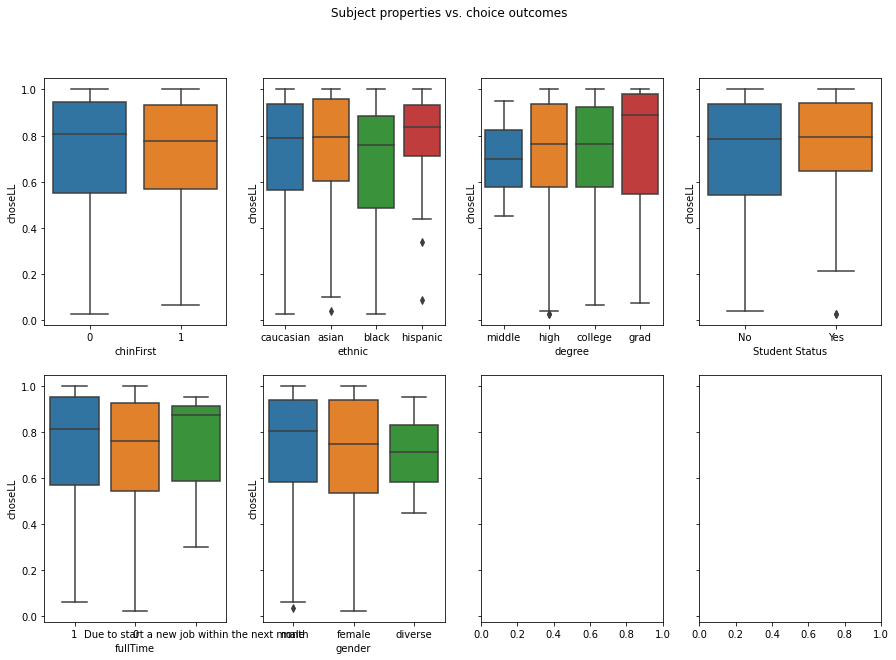

In [5]:
fig, axes = plt.subplots(2, 4, sharey=True, figsize=(3*5, 2*5))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = ['chinFirst', 'ethnic', 'degree', 'Student Status']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[0, i], x=predictors[i], y='choseLL', 
                data=data_subject.loc[data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])])
predictors = ['fullTime', 'gender']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[1, i], x=predictors[i], y='choseLL', 
                data=data_subject.loc[data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC'])])

In [6]:
for col in ['Nationality', 'Country of Birth']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0               count
Nationality              
Bangladesh              2
Cambodia                1
Canada                  1
Chile                   1
China                   1
Croatia                 1
Greece                  3
Hungary                 1
India                   4
Israel                  2
Italy                   7
Jamaica                 1
Korea                   2
Mexico                  4
Nepal                   1
Netherlands             1
Peru                    1
Poland                 10
Portugal                2
Russian Federation      1
South Africa            1
Spain                   2
United Kingdom          6
United States         152
Vietnam                 1


col_0             count
Country of Birth       
Bangladesh            2
Chile                 1
China                 4
Germany               2
Greece                2
Hong Kong             1
Hungary               1
India                 6
Israel                2
Italy                 5
Jamaica 

# Visualize eye movements

## Individual

In [7]:
data_subject.loc[data_subject['fps']>10, 'run_id']

0      309
1      327
2      244
3      358
4      429
      ... 
202    328
204    231
205    210
206    422
207    146
Name: run_id, Length: 170, dtype: int64

106    21.062559
Name: fps, dtype: float64


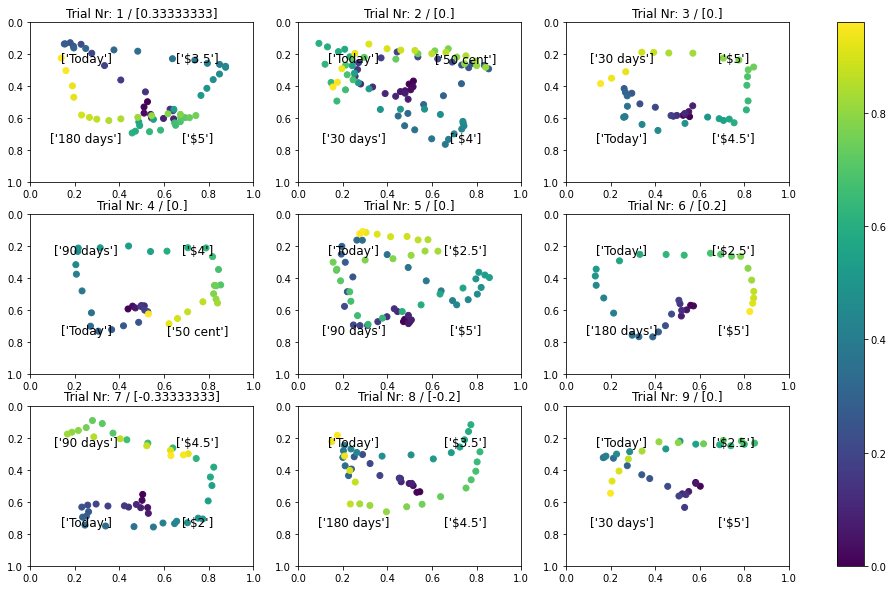

In [8]:
data_plot = data_et_choice.loc[data_et_choice['run_id']==128, :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_plot = add_var_to_data_et(data_plot, data_trial_choice, 'trial_duration_exact')
data_plot['t_task_rel'] = data_plot['t_task'] / data_plot['trial_duration_exact']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 10))
axes = axes.ravel()

thisSubject = data_plot['run_id'].unique()[0]
print(data_subject.loc[data_subject['run_id']==thisSubject, 'fps'])
for i in range(0, 9):
    
    df_thisTrial = data_trial_choice.loc[
        (data_trial_choice['run_id']==thisSubject) &
        (data_trial_choice['withinTaskIndex']==50+i+1), :]
    
    payne = df_thisTrial['payneIndex'].values
    
    axes_data = data_plot.loc[data_plot['withinTaskIndex']==i+1, :]
    im = axes[i].scatter(axes_data['x'], axes_data['y'], c=axes_data['t_task_rel'], cmap='viridis')
    axes[i].set_title('Trial Nr: ' + str(i+1) + ' / ' + str(payne))
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
    # JS and python y coordinates seem to be inverted
    axes[i].text(0.25, 0.75, df_thisTrial['option_TL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.25, 0.25, df_thisTrial['option_BL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.75, df_thisTrial['option_TR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.25, df_thisTrial['option_BR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    
fig.colorbar(im, ax=axes)
plt.show()

106    21.062559
Name: fps, dtype: float64


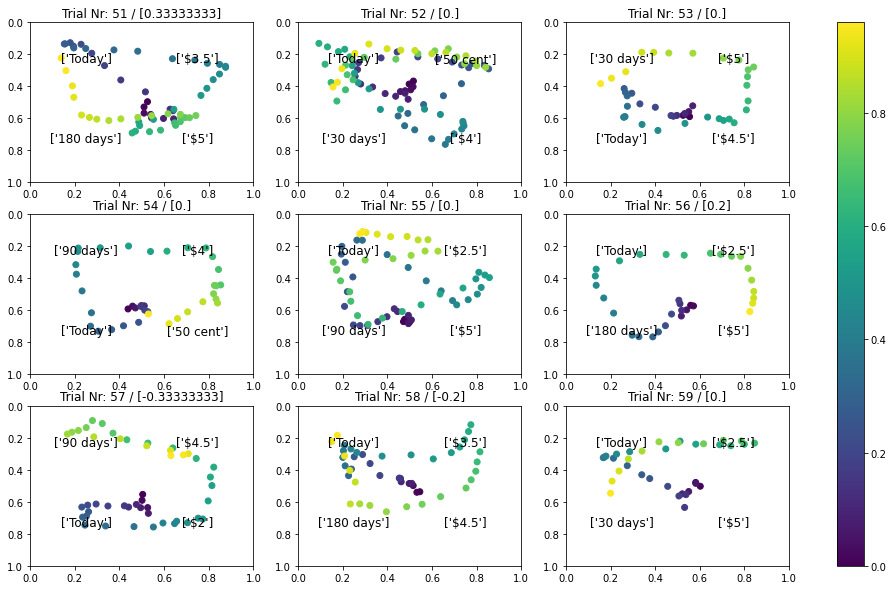

In [9]:
data_plot = data_et_choice.loc[
    (data_et_choice['run_id']==128), :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_plot = add_var_to_data_et(data_plot, data_trial_choice, 'trial_duration_exact')
data_plot['t_task_rel'] = data_plot['t_task'] / data_plot['trial_duration_exact']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(17, 10))
axes = axes.ravel()

thisSubject = data_plot['run_id'].unique()[0]
print(data_subject.loc[data_subject['run_id']==thisSubject, 'fps'])
for i in range(0, 9):
    
    df_thisTrial = data_trial_choice.loc[
        (data_trial_choice['run_id']==thisSubject) &
        (data_trial_choice['withinTaskIndex']==50+i+1), :]
    
    payne = df_thisTrial['payneIndex'].values
    
    axes_data = data_plot.loc[data_plot['withinTaskIndex']==i+1, :]
    im = axes[i].scatter(axes_data['x'], axes_data['y'], c=axes_data['t_task_rel'], cmap='viridis')
    axes[i].set_title('Trial Nr: ' + str(50+i+1) + ' / ' + str(payne))
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
    # JS and python y coordinates seem to be inverted
    axes[i].text(0.25, 0.75, df_thisTrial['option_TL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.25, 0.25, df_thisTrial['option_BL'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.75, df_thisTrial['option_TR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    axes[i].text(0.75, 0.25, df_thisTrial['option_BR'].values, 
                 size=12, ha="center", transform=axes[i].transAxes)
    
fig.colorbar(im, ax=axes)
plt.show()

In [10]:
data_trial_choice.loc[
    (data_trial_choice['run_id']==128) & 
    (data_trial_choice['choseLL']==1) & 
    (
        (data_trial_choice['option_TL']=='90 days') |
        (data_trial_choice['option_TR']=='90 days') |
        (data_trial_choice['option_BL']=='90 days') |
        (data_trial_choice['option_BR']=='90 days')
    ), 
        [
        'run_id', 'withinTaskIndex', 
        'option_TL','option_BL', 'option_TR', 'option_BR', 'k', 
        'trial_duration_exact', 'x_count', 'fps', 
        'choseTop', 'choseLL', 

        'optionIndex', 'attributeIndex', 'payneIndex']
]

,run_id,withinTaskIndex,option_TL,option_BL,option_TR,option_BR,k,trial_duration_exact,x_count,fps,choseTop,choseLL,optionIndex,attributeIndex,payneIndex
405,128,7.0,$5,50 cent,90 days,Today,0.100000,2183,47.0,21.530005,1,1,0.030303,0.151515,0.600000
408,128,10.0,$4,50 cent,90 days,Today,0.077778,1631,35.0,21.459227,1,1,-0.200000,0.700000,0.000000
414,128,16.0,$1,$4.5,Today,90 days,0.038889,1211,27.0,22.295623,0,1,0.076923,0.538462,0.333333
420,128,22.0,$5,$3,90 days,Today,0.007407,1625,32.0,19.692308,1,1,0.473684,0.052632,-1.000000
421,128,23.0,$4.5,$3.5,90 days,Today,0.003175,1415,32.0,22.614841,1,1,-0.400000,0.100000,0.333333
427,128,29.0,$1.5,$4,Today,90 days,0.018519,1324,30.0,22.658610,0,1,-0.142857,0.571429,0.000000
434,128,36.0,$1,$5,Today,90 days,0.044444,1139,25.0,21.949078,0,1,-1.000000,0.200000,0.000000
448,128,50.0,90 days,Today,$4,$1.5,0.018519,1559,35.0,22.450289,1,1,-0.411765,0.058824,0.000000
452,128,54.0,90 days,Today,$4,50 cent,0.077778,1272,25.0,19.654088,1,1,1.000000,1.000000,0.000000
453,128,55.0,Today,90 days,$2.5,$5,0.011111,1717,39.0,22.714036,0,1,0.090909,0.090909,0.000000


In [11]:
data_trial_choice.loc[
    ((data_trial_choice['run_id']==43) & 
    (data_trial_choice['withinTaskIndex']==7)) |
    ((data_trial_choice['run_id']==128) & 
    (data_trial_choice['withinTaskIndex']==59)), 
    [
        'run_id', 'withinTaskIndex', 
        'option_TL','option_BL', 'option_TR', 'option_BR', 'k', 
        'trial_duration_exact', 'x_count', 'fps', 
        'choseTop', 'choseLL', 

        'optionIndex', 'attributeIndex', 'payneIndex']
]

,run_id,withinTaskIndex,option_TL,option_BL,option_TR,option_BR,k,trial_duration_exact,x_count,fps,choseTop,choseLL,optionIndex,attributeIndex,payneIndex
457,128,59.0,Today,30 days,$2.5,$5,0.033333,1406,31.0,22.048364,0,1,-0.727273,-0.272727,0.0
15864,43,7.0,Today,90 days,$4,$5,0.002778,2319,82.0,35.360069,1,0,-0.487179,0.487179,0.6


## Heatmap

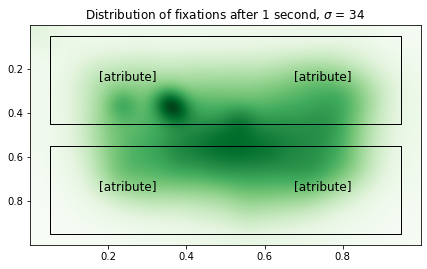

<Figure size 432x288 with 0 Axes>

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter


x = data_et_choice.loc[data_et_choice['t_task']>1000, 'x']
y = data_et_choice.loc[data_et_choice['t_task']>1000, 'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent



# Create figure and axes
fig,ax = plt.subplots(figsize=(7, 7))

s=34
img, extent = myplot(x, y, s=s)
ax.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))

rect = patches.Rectangle((0.05,0.05),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)
rect = patches.Rectangle((0.05,0.55),0.9,0.4,linewidth=1, edgecolor='black',facecolor='none')
ax.add_patch(rect)

xPos = [0.25, 0.75, 0.25, 0.75]
yPos = [0.25, 0.25, 0.75, 0.75]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '[atribute]', size=12, ha="center")

ax.set_title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)

plt.show()
plt.savefig('plots/choice_heatmap.png')

# Correlations

## AVG reaction time for each subject

## subject-level

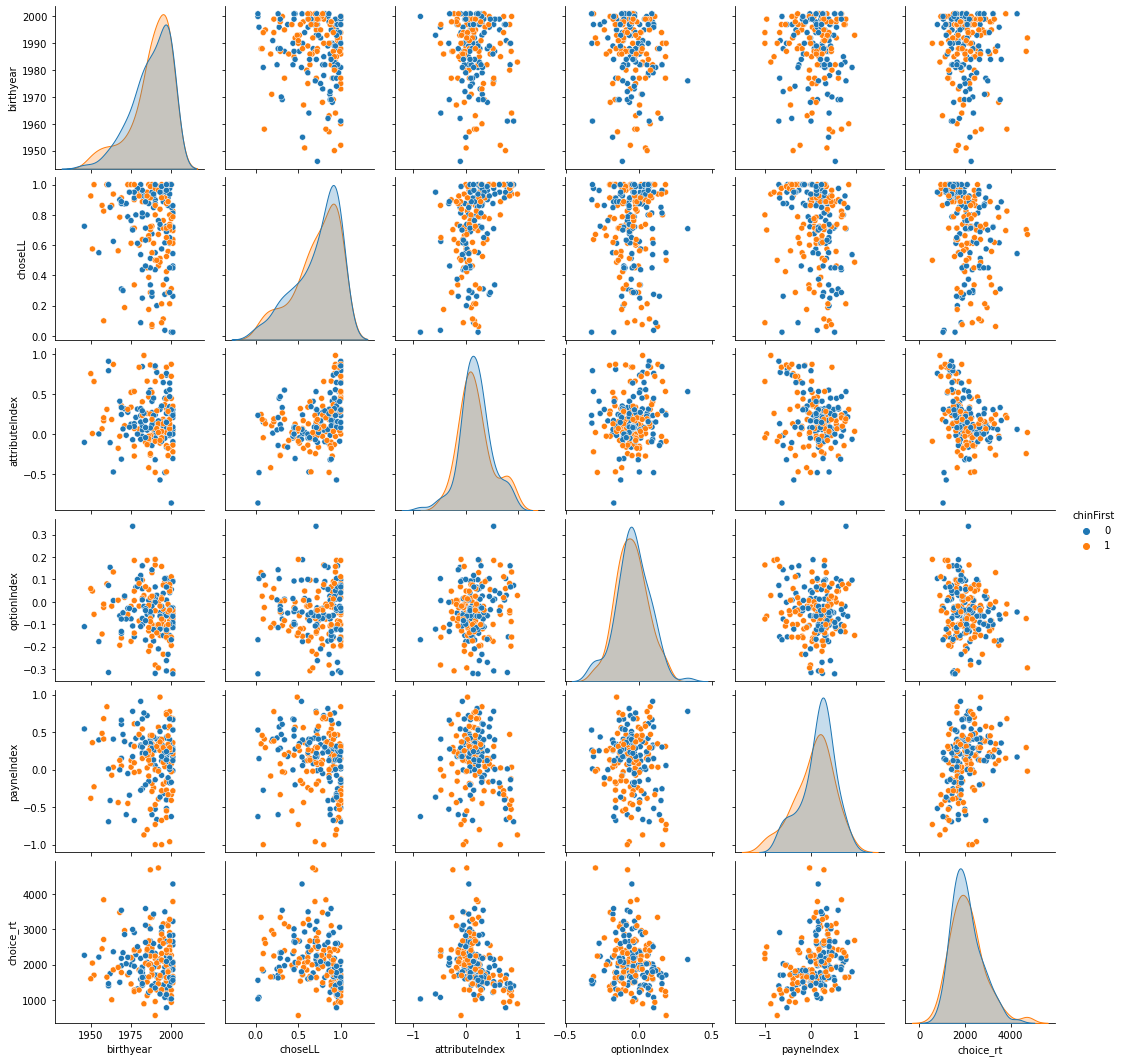

In [13]:
data_plot = data_subject.loc[
    data_subject['run_id'].isin(data_trial_choice['run_id'].unique()), :]

corr_columns = ['birthyear', 'choseLL', 'attributeIndex', 'optionIndex', 'payneIndex', 'choice_rt']
sns.pairplot(data_plot.loc[:, np.append(corr_columns, ['chinFirst'])], hue='chinFirst')

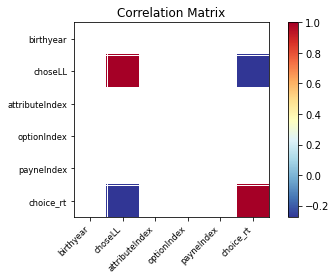

,birthyear,choseLL,attributeIndex,optionIndex,payneIndex,choice_rt
birthyear,-,,,,,
choseLL,-0.099,-,***,,*,***
attributeIndex,-0.08,0.43,-,*,**,***
optionIndex,-0.13,-0.031,0.149,-,,*
payneIndex,-0.042,-0.171,-0.207,-0.062,-,***
choice_rt,-0.011,-0.275,-0.352,-0.172,0.321,-


In [14]:
corr_matrix = np.corrcoef(data_plot[corr_columns].T)
smg.plot_corr(corr_matrix, xnames=data_plot[corr_columns].columns)
plt.show()
data_plot[corr_columns].rcorr()

In [15]:
data_plot[corr_columns].rcorr(upper='n')

,birthyear,choseLL,attributeIndex,optionIndex,payneIndex,choice_rt
birthyear,-,202,201,201,198,202
choseLL,-0.099,-,208,208,205,209
attributeIndex,-0.08,0.43,-,208,205,208
optionIndex,-0.13,-0.031,0.149,-,205,208
payneIndex,-0.042,-0.171,-0.207,-0.062,-,205
choice_rt,-0.011,-0.275,-0.352,-0.172,0.321,-


## trial-level

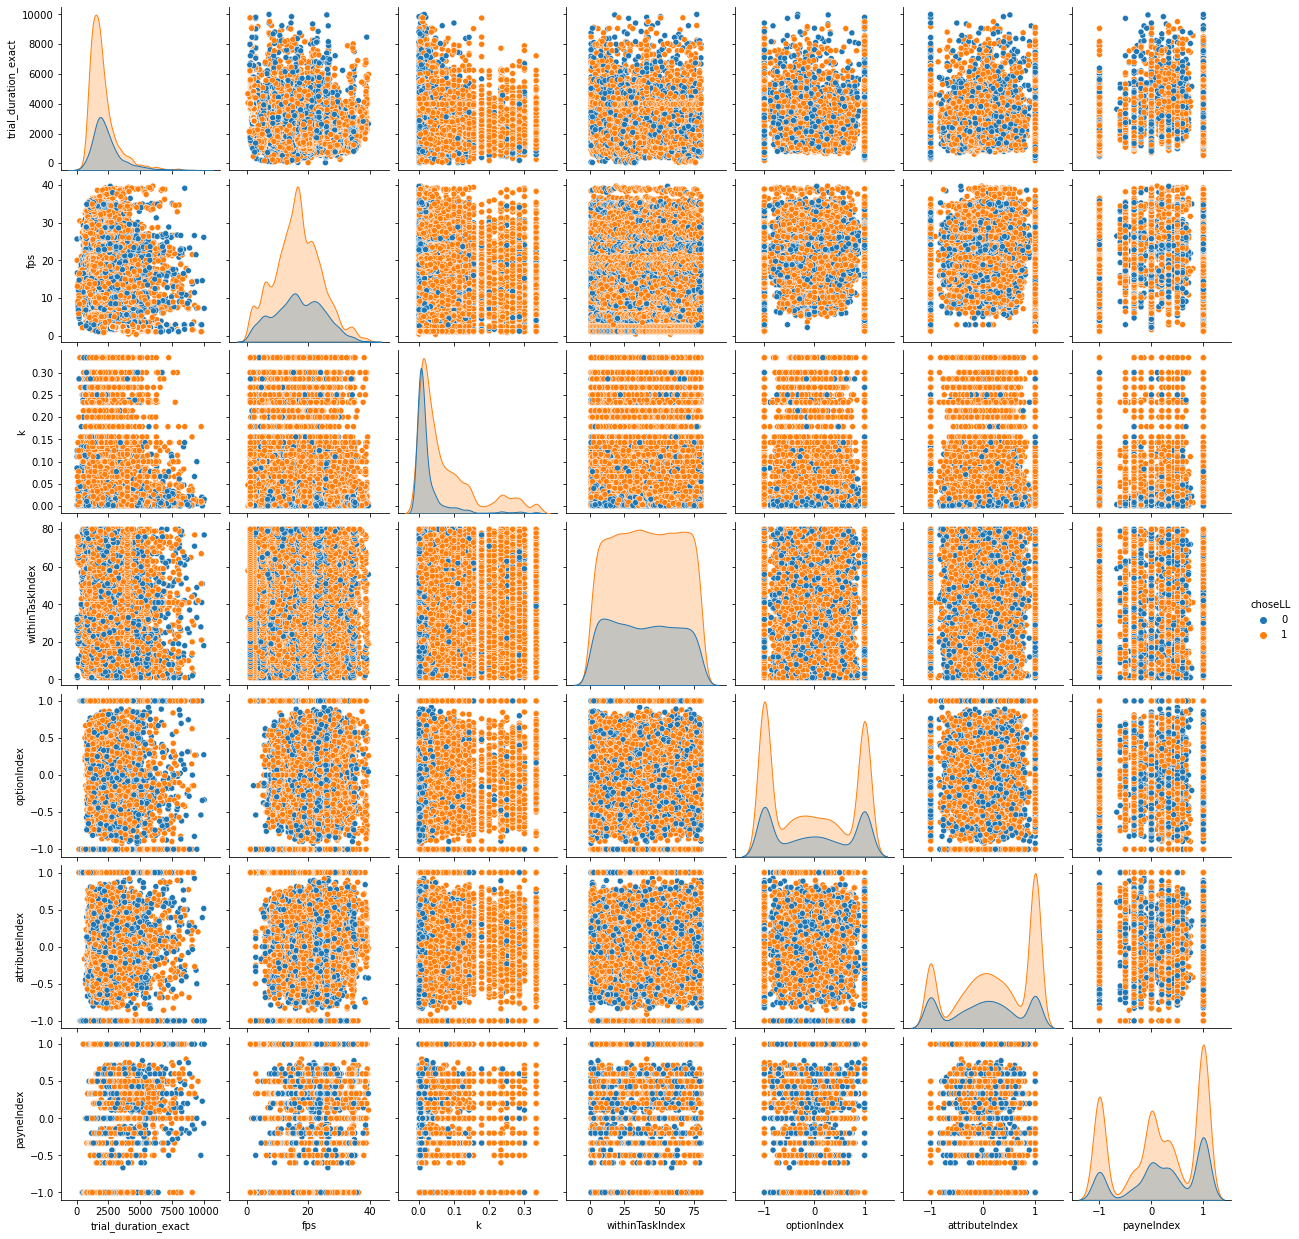

In [16]:
corr_columns = ['trial_duration_exact', 'fps', 'k', 'withinTaskIndex', 
                'optionIndex', 'attributeIndex', 'payneIndex']

sns.pairplot(data_trial_choice.loc[:, np.append(corr_columns, ['choseLL'])], hue='choseLL')